Main: Life Expectency Data set code

In [ ]:

## importing necessary libraries

import pandas as pd
import os
folder_path = '../IHME Project/Life Expectency Data'

# List all the csv files in the folder



csv_files = [x for x in os.listdir(folder_path) if x.endswith('.CSV')] ## this is an example of list comprehension

csv_files



# lets create an empty list to store the dataframes

dataframes = []



# lets loop over the list of CSV files and read each one



for file in csv_files:

file_path = os.path.join(folder_path, file)

df = pd.read_csv(file_path)

dataframes.append(df)





reduced_dataframe=[]



for i in range (0,20):


## lets extract the total life expectency and only of the age group less than 1 year olds.



df2=dataframes[i].loc[(dataframes[i]['race_name'] == 'Total') & (dataframes[i]['age_name'] == '<1 year')]



## lets remove empty cells



df3=df2.dropna()



## As the dataframe consists of life expectencey at the state level as well

## lets gather only those with county, since fips for state end at 56, will set the condition to be greater than this to get the data at the county level.



df4=df3.loc[(df3['fips'] > 60)]





## lets delete these columns.

df5 = df4.drop(['measure_id', 'location_id', 'fips','measure_name', 'race_id', 'race_name', 'sex_id', 'sex_name', 'age_group_id',

'age_name', 'metric_id', 'metric_name', 'upper', 'lower'], axis=1)



## lets rename the column val to mean life expectency.

df5 = df5.rename(columns={'val': 'MeanLifeExpectency'})



reduced_dataframe.append(df5)

final_df=pd.concat(reduced_dataframe,ignore_index=True)

final_df



final_df.to_csv("All_year_dataframe.csv")



Lets examine the data structure in our raster files and shp files.

In [12]:
import pathlib
import rasterio
import fiona
import pandas as pd
from shapely.geometry import shape # Useful for more advanced geometry analysis
from collections import defaultdict

# --- Configuration ---
root_dir = pathlib.Path("/Users/faizahmad/Desktop/NewLiv/data")  # 📂 Adjust this path

# --- Function to Extract Metadata from TIF (Raster) Files (from previous version, unchanged) ---
def extract_tif_metadata(directory: pathlib.Path) -> pd.DataFrame:
    """
    Extracts common metadata from GeoTIFF files in a given directory.
    """
    tif_files = sorted(directory.glob("*.tif"))
    records = []
    for f in tif_files:
        try:
            with rasterio.open(f) as src:
                meta = src.meta
                records.append({
                    "file": f.name,
                    "type": "raster",
                    "crs": meta["crs"].to_string() if meta["crs"] else None,
                    "width": meta["width"],
                    "height": meta["height"],
                    "transform": tuple(round(x, 10) for x in meta["transform"][:6]),
                    "dtype": meta["dtype"],
                    "nodata": meta["nodata"],
                    "bands": meta["count"],
                    "resolution_x": round(meta["transform"].a, 10),
                    "resolution_y": round(meta["transform"].e, 10),
                    "driver": meta["driver"],
                })
        except rasterio.errors.RasterioIOError as e:
            print(f"⚠️  Skipping {f.name}: Not a valid GeoTIFF or read error: {e}")
        except Exception as e:
            print(f"⚠️  An unexpected error occurred with {f.name}: {e}")
    return pd.DataFrame(records)

# --- ❷ Further Improved Function to Extract Metadata from SHP (Vector) Files ---
def extract_shp_metadata(directory: pathlib.Path) -> pd.DataFrame:
    """
    Extracts common metadata from Shapefile files in a given directory.
    """
    shp_files = sorted(directory.glob("*.shp"))
    records = []
    for f in shp_files:
        try:
            with fiona.open(f) as src:
                # --- Robustly extract properties schema ---
                properties_schema = {}
                if 'properties' in src.schema and src.schema['properties']:
                    for prop_name, prop_details in src.schema["properties"].items():
                        if isinstance(prop_details, dict) and 'type' in prop_details:
                            properties_schema[prop_name] = prop_details['type']
                        else:
                            # Fallback if 'type' key is missing or prop_details is not a dict
                            properties_schema[prop_name] = str(prop_details) # Coerce to string for inspection
                else:
                    properties_schema = {} # No properties found or empty schema

                # --- Get unique geometry types (sampling for performance) ---
                unique_geometry_types = set()
                try:
                    for i, feature in enumerate(src):
                        if i >= 1000: # Sample up to 1000 features to avoid slow processing
                            break
                        if feature and 'geometry' in feature and feature['geometry'] and 'type' in feature['geometry']:
                            unique_geometry_types.add(feature['geometry']['type'])
                except StopIteration:
                    pass # Handle empty shapefiles gracefully
                except Exception as geom_e:
                    print(f"⚠️  Error getting geometry type for {f.name}: {geom_e}")
                    unique_geometry_types.add("Error_reading_geometry")


                records.append({
                    "file": f.name,
                    "type": "vector",
                    "crs": src.crs_wkt,  # WKT string for CRS
                    "geometry_types": list(unique_geometry_types) if unique_geometry_types else [], # List of detected geometry types
                    "properties_schema": properties_schema, # Field names and types
                    "bounds": src.bounds, # (min_x, min_y, max_x, max_y)
                    "driver": src.driver,
                    "feature_count": len(src), # Number of features in the shapefile
                    "encoding": src.encoding if hasattr(src, 'encoding') else None, # Character encoding for DBF
                })
        except fiona.errors.DriverError as e:
            print(f"⚠️  Skipping {f.name}: Not a valid Shapefile or read error: {e}")
        except Exception as e:
            print(f"⚠️  An unexpected error occurred with {f.name}: {e}")
            # This line will help diagnose the exact structure if the above fixes don't work
            # if 'src' in locals():
            #     print(f"Debug: Schema for {f.name}: {src.schema}")
            #     if 'properties' in src.schema:
            #         print(f"Debug: Properties for {f.name}: {src.schema['properties']}")
    return pd.DataFrame(records)

# --- ❸ Run Extraction and Analysis ---

print("--- Extracting TIF Metadata ---")
df_tifs = extract_tif_metadata(root_dir)
if not df_tifs.empty:
    print(df_tifs.to_string()) # Use .to_string() to avoid truncation
    print("\n⚠️  Inconsistent fields for TIFs:", end=" ")
    tif_problems = {
        col: df_tifs[col].unique().tolist()
        for col in ["crs", "width", "height", "transform", "dtype", "nodata", "bands", "resolution_x", "resolution_y", "driver"]
        if len(df_tifs[col].unique()) > 1
    }
    print(tif_problems if tif_problems else "None 🎉")
else:
    print("No TIF files found or processed.")


print("\n--- Extracting SHP Metadata ---")
df_shps = extract_shp_metadata(root_dir)
if not df_shps.empty:
    print(df_shps.to_string()) # Use .to_string() to avoid truncation

    print("\n⚠️  Inconsistent fields for SHPs:", end=" ")
    # For SHP consistency, 'bounds' and 'feature_count' are almost certainly
    # going to be different for each file, so exclude them from the default check.

    # Convert 'properties_schema' dictionary to a sorted string for hashing
    properties_schema_str = df_shps['properties_schema'].apply(lambda x: str(sorted(x.items())))
    geometry_types_hashable = df_shps['geometry_types'].apply(lambda x: tuple(sorted(x)))

    shp_problems = {
        "crs": df_shps["crs"].unique().tolist() if len(df_shps["crs"].unique()) > 1 else None,
        "geometry_types": geometry_types_hashable.unique().tolist() if len(geometry_types_hashable.unique()) > 1 else None,
        "properties_schema": properties_schema_str.unique().tolist() if len(properties_schema_str.unique()) > 1 else None,
        "driver": df_shps["driver"].unique().tolist() if len(df_shps["driver"].unique()) > 1 else None,
        "encoding": df_shps["encoding"].unique().tolist() if len(df_shps["encoding"].unique()) > 1 else None,
    }
    # Remove None values
    shp_problems = {k: v for k, v in shp_problems.items() if v is not None}
    print(shp_problems if shp_problems else "None 🎉")

    # Optional: More specific check for schema consistency, if fields should be identical
    if len(properties_schema_str.unique()) > 1:
        print("\n💡 Note: 'properties_schema' field consistency check shows differences in field names or types.")
        # You could add logic here to print the differing schemas for inspection
else:
    print("No SHP files found or processed.")

# --- Optional: Combine and Analyze if you need a single DataFrame ---
# You can concatenate them if you add a 'type' column to distinguish
# combined_df = pd.concat([df_tifs, df_shps], ignore_index=True)
# print("\n--- Combined Metadata (if applicable) ---")
# print(combined_df)

--- Extracting TIF Metadata ---
                      file    type        crs  width  height                                              transform    dtype         nodata  bands  resolution_x  resolution_y driver
0         5_Bf_2010_Da.tif  raster  EPSG:4326   4320    2160  (0.0833333333, 0.0, -180.0, 0.0, -0.0833333333, 90.0)  float64 -1.700000e+308      1      0.083333     -0.083333  GTiff
1         5_Bf_2015_Da.tif  raster  EPSG:4326   4320    2160  (0.0833333333, 0.0, -180.0, 0.0, -0.0833333333, 90.0)  float32  -3.400000e+38      1      0.083333     -0.083333  GTiff
2         5_Ch_2010_Da.tif  raster  EPSG:4326   4320    2160  (0.0833333333, 0.0, -180.0, 0.0, -0.0833333333, 90.0)  float64 -1.700000e+308      1      0.083333     -0.083333  GTiff
3         5_Ch_2015_Da.tif  raster  EPSG:4326   4320    2160  (0.0833333333, 0.0, -180.0, 0.0, -0.0833333333, 90.0)  float32  -3.400000e+38      1      0.083333     -0.083333  GTiff
4         5_Ct_2010_Da.tif  raster  EPSG:4326   4320    21

Main: Important:  Main code that generates csv from raster files

In [1]:
import os, re
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
import geopandas as gpd
import pandas as pd
from rasterstats import zonal_stats
from tqdm import tqdm

RASTER_DIR = Path("/Users/faizahmad/Desktop/NewLiv/data")
COUNTY_SHP = Path("/Users/faizahmad/Desktop/NewLiv/data/cb_2023_us_county_500k.shp")
OUT_CSV    = Path("county_livestock_2010_2015_2020.csv")
CORES      = max(os.cpu_count() - 1, 1)

def load_counties():
    g = gpd.read_file(COUNTY_SHP).to_crs("EPSG:4326")
    geoids = [c for c in g.columns if c.upper().startswith("GEOID")]
    col = "GEOID" if "GEOID" in geoids else sorted(geoids, key=len)[0]
    if col != "GEOID":
        g = g.rename(columns={col: "GEOID"})
    if "ALAND" in g.columns:
        g["area_km2"] = g["ALAND"] / 1e6
    else:
        g["area_km2"] = g.to_crs(5070).geometry.area / 1e6
    return g[["GEOID","area_km2","geometry"]]

def one_raster(tif, counties):
    year = re.search(r"(\d{4})", tif.name).group(1)
    species = tif.stem.split('.')[-1]
    stats = zonal_stats(
        counties, tif,
        stats=["mean","count"],
        nodata=None,
        all_touched=True
    )
    df = pd.DataFrame(stats)
    df["GEOID"] = counties["GEOID"].values
    df["year"]  = year
    df["species"] = species
    df["head_count"] = df["mean"] * counties["area_km2"]
    return df[["GEOID","year","species","head_count","mean","count"]].rename(
        columns={"mean":"mean_density","count":"cell_count"}
    )

def run_batch():
    counties = load_counties()
    tifs = sorted(RASTER_DIR.glob("*.tif"))
    pieces = []
    with ThreadPoolExecutor(max_workers=CORES) as ex:
        futs = {ex.submit(one_raster, tif, counties): tif for tif in tifs}
        for f in tqdm(as_completed(futs), total=len(futs), desc="processing"):
            pieces.append(f.result())
    out = pd.concat(pieces, ignore_index=True)
    out.to_csv(OUT_CSV, index=False)
    return out

df = run_batch()


processing:   0%|          | 0/22 [00:07<?, ?it/s]


KeyboardInterrupt: 

looking the health of our livestock csv, sanity check

In [10]:
import pandas as pd

# Assuming you want to use the DataFrame generated by the main() function in the previous code,
# which is saved as OUT_CSV. We'll load it and show the head, statistics, and unique values.


# Load the DataFrame from the output CSV
df = pd.read_csv(OUT_CSV)

# Show the head of the DataFrame
print(df.head())

# Show basic statistics
print(df.describe(include='all'))

# Show unique values for each column
for col in df.columns:
    unique_vals = df[col].unique()
    print(f"\nUnique values in '{col}':")
    print(unique_vals)

   GEOID  year       species  head_count  mean_density  cell_count
0   1003  2015  5_Bf_2015_Da         NaN           NaN           0
1   1069  2015  5_Bf_2015_Da         NaN           NaN           0
2   1005  2015  5_Bf_2015_Da         NaN           NaN           0
3   1119  2015  5_Bf_2015_Da         NaN           NaN           0
4   5091  2015  5_Bf_2015_Da         NaN           NaN           0
               GEOID          year       species    head_count  mean_density  \
count   71170.000000  71170.000000         71170  6.451300e+04  6.451300e+04   
unique           NaN           NaN            22           NaN           NaN   
top              NaN           NaN  5_Bf_2015_Da           NaN           NaN   
freq             NaN           NaN          3235           NaN           NaN   
mean    31522.781453   2014.545455           NaN  4.422897e+06  3.515173e+03   
std     16429.399650      3.962663           NaN  4.575103e+07  3.846188e+04   
min      1001.000000   2010.000000    

sanity check: Plotting one species for more sanity check

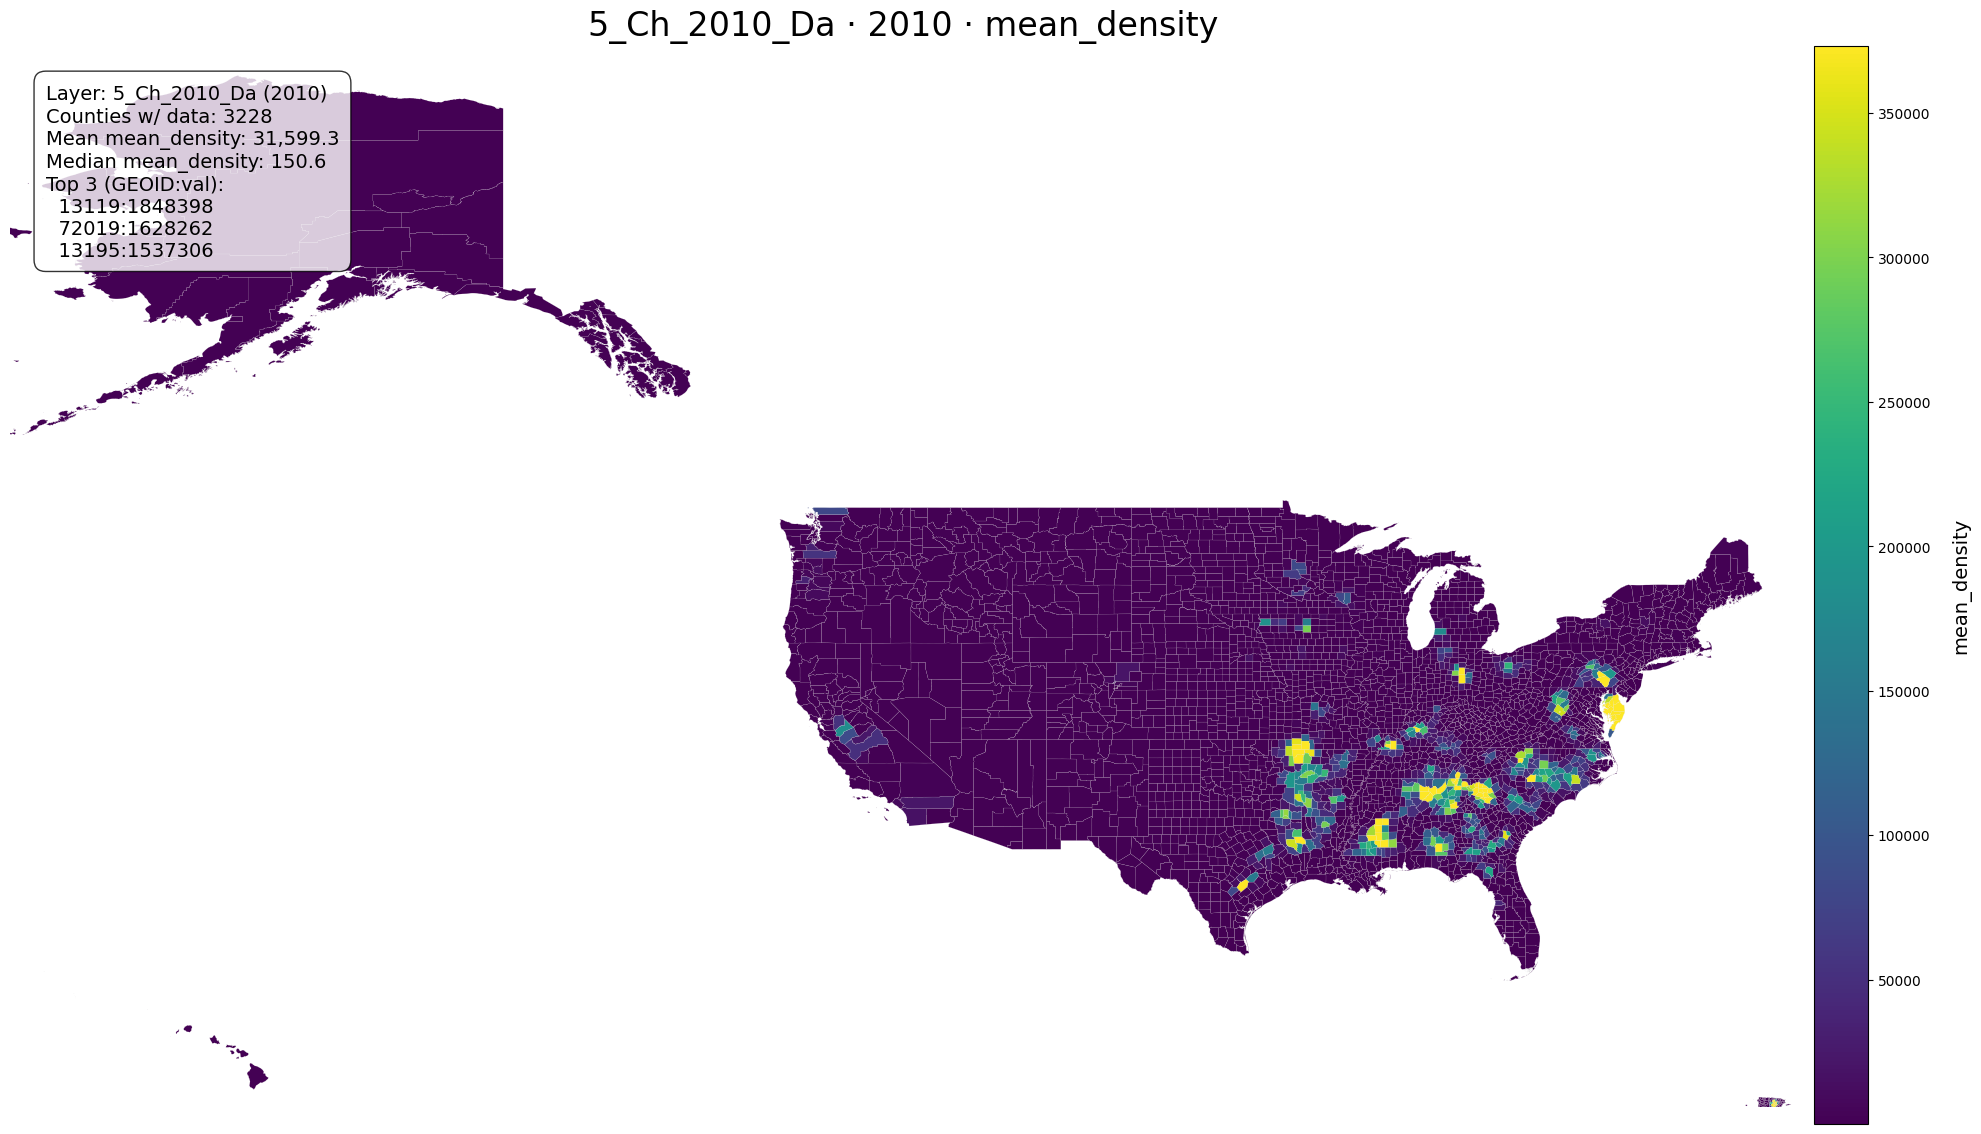

In [8]:
# ────────── STEP 0: user choices ──────────
CSV_FILE   = "/Users/faizahmad/Desktop/NewLiv/data/county_livestock_2010_2015_2020.csv"
COUNTY_SHP = "/Users/faizahmad/Desktop/NewLiv/data/cb_2023_us_county_500k.shp"

YEAR     = 2010
SPECIES  = "5_Ch_2010_Da"
METRIC   = "mean_density"   # or "head_count"
# ──────────────────────────────────────────

import geopandas as gpd, pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

# 1. Load & filter table
df = pd.read_csv(CSV_FILE, dtype={"GEOID": str})
df["GEOID"] = df["GEOID"].str.zfill(5)
sub = (
    df[(df["year"] == YEAR) &
       (df["species"] == SPECIES) &
       (df["cell_count"] > 0)]
    .loc[:, ["GEOID", METRIC]]
)

# 2. Load counties & harmonize GEOID
g = gpd.read_file(COUNTY_SHP).to_crs("EPSG:4326")
geo_cols = [c for c in g.columns if c.upper().startswith("GEOID")]
chosen   = sorted(geo_cols, key=len)[0]
g = g.rename(columns={chosen:"GEOID"})
for c in geo_cols:
    if c!=chosen:
        g = g.drop(columns=c)
g["GEOID"] = g["GEOID"].astype(str).str.zfill(5)

# 3. Merge
map_df = g.merge(sub, on="GEOID", how="left")

# 4. Colour stretch (clip 2–98 %)
vals = map_df[METRIC].dropna()
vmin, vmax = np.percentile(vals, [2, 98]) if len(vals) else (0,1)

# 5. Summary + top 3
n_county = len(vals)
mean_v   = vals.mean()
med_v    = np.median(vals)
top3     = map_df.nlargest(3, METRIC)[["GEOID", METRIC]]
top3_list = [f"{row.GEOID}:{row[METRIC]:.0f}" for _,row in top3.iterrows()]

textstr = (
    f"Layer: {SPECIES} ({YEAR})\n"
    f"Counties w/ data: {n_county}\n"
    f"Mean {METRIC}: {mean_v:,.1f}\n"
    f"Median {METRIC}: {med_v:,.1f}\n"
    f"Top 3 (GEOID:val):\n  " + "\n  ".join(top3_list)
)

# 6. Plot (big) + zoom to US extents
fig, ax = plt.subplots(figsize=(24,14), dpi=100)
map_df.plot(column=METRIC,
            cmap="viridis",
            ax=ax, vmin=vmin, vmax=vmax,
            linewidth=0.08, edgecolor="gainsboro")
ax.axis("off")
ax.set_title(f"{SPECIES} · {YEAR} · {METRIC}", fontsize=24, pad=20)

# **Zoom to include lower 48, Alaska & Hawaii**
ax.set_xlim(-170, -65)
ax.set_ylim(18,   72)

# 7. Colour bar
sm = plt.cm.ScalarMappable(cmap="viridis",
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.01)
cbar.set_label(METRIC, rotation=90, labelpad=15, fontsize=14)

# 8. Text box (stats + key features)
bbox = dict(boxstyle="round,pad=0.6", facecolor="white", alpha=0.8)
ax.text(0.02, 0.98, textstr,
        transform=ax.transAxes,
        fontsize=14,
        verticalalignment="top",
        bbox=bbox)

plt.show()


Looking into the files 

In [25]:
import pandas as pd

# File paths
lifeex_csv = '/Users/faizahmad/Desktop/NewLiv/data/summer 2025/LifeEX_All_year_dataframe.csv'
livestock_csv = '/Users/faizahmad/Desktop/NewLiv/data/summer 2025/county_livestock_2010_2015_2020.csv'
Combined_csv = '/Users/faizahmad/Desktop/NewLiv/data/summer 2025/combined_final_dataset_ML_DL.csv'
# Load CSVs
df_lifeex = pd.read_csv(lifeex_csv, dtype={'fips': str})
df_livestock = pd.read_csv(livestock_csv, dtype={'GEOID': str})
df_combined = pd.read_csv(Combined_csv, dtype={'fips': str, 'GEOID': str})
# Standardize column names for comparison
df_lifeex['fips'] = df_lifeex['fips'].str.zfill(5)
df_livestock['GEOID'] = df_livestock['GEOID'].str.zfill(5)
df_combined['fips'] = df_combined['fips'].str.zfill(5)

# Unique values
unique_fips_lifeex = df_lifeex['fips'].nunique()
unique_fips_livestock = df_livestock['GEOID'].nunique()
unique_fips_combined = df_combined['fips'].nunique()

print(f"Unique county FIPS in LifeEX CSV: {unique_fips_lifeex}")
print(f"Unique county GEOID in Livestock CSV: {unique_fips_livestock}")
print(f"Unique county FIPS in Combined CSV: {unique_fips_combined}")

# Check for missing values
missing_lifeex = df_lifeex.isnull().sum()
missing_livestock = df_livestock.isnull().sum()
missing_combined = df_combined.isnull().sum()   
# Data stats
print("\nLifeEX DataFrame stats:")
print(df_lifeex.describe(include='all'))
print("\nLivestock DataFrame stats:")
print(df_livestock.describe(include='all'))
print("\nCombined DataFrame stats:")
print(df_combined.describe(include='all'))  
print("\nLivestock DataFrame stats:")
print(df_livestock.describe(include='all'))

Unique county FIPS in LifeEX CSV: 3178
Unique county GEOID in Livestock CSV: 3235
Unique county FIPS in Combined CSV: 3309

LifeEX DataFrame stats:
          Unnamed: 0         location_name   fips          year  \
count   63560.000000                 63560  63560  63560.000000   
unique           NaN                  3177   3178           NaN   
top              NaN  District of Columbia  001.0           NaN   
freq             NaN                    40     20           NaN   
mean    31779.500000                   NaN    NaN   2009.500000   
std     18348.335892                   NaN    NaN      5.766327   
min         0.000000                   NaN    NaN   2000.000000   
25%     15889.750000                   NaN    NaN   2004.750000   
50%     31779.500000                   NaN    NaN   2009.500000   
75%     47669.250000                   NaN    NaN   2014.250000   
max     63559.000000                   NaN    NaN   2019.000000   

        MeanLifeExpectency  
count         6356

Looking into the files 

In [5]:
import pandas as pd

DATA_DIR = "/Users/faizahmad/Desktop/NewLiv/data/summer 2025"

# 1. LifeEX (your “final” without livestock)
lifeex = pd.read_csv(f"{DATA_DIR}/LifeEX_All_year_dataframe.csv", dtype={"fips": str})
print("LifeEX shape:", lifeex.shape)
print(lifeex.dtypes)
display(lifeex.head())

# 2. Livestock
liv = pd.read_csv(f"{DATA_DIR}/county_livestock_2010_2015_2020.csv", dtype={"GEOID": str})
print("\nLivestock shape:", liv.shape)
print(liv.dtypes)
display(liv.head())


LifeEX shape: (63560, 5)
Unnamed: 0              int64
location_name          object
fips                   object
year                    int64
MeanLifeExpectency    float64
dtype: object


,Unnamed: 0,location_name,fips,year,MeanLifeExpectency
0,0,Alabama,1.0,2016,75.264468
1,1,Autauga County (Alabama),1001.0,2016,75.877864
2,2,Baldwin County (Alabama),1003.0,2016,77.913070
3,3,Barbour County (Alabama),1005.0,2016,74.919864
4,4,Bibb County (Alabama),1007.0,2016,73.667331



Livestock shape: (71170, 6)
GEOID            object
year              int64
species          object
head_count      float64
mean_density    float64
cell_count        int64
dtype: object


,GEOID,year,species,head_count,mean_density,cell_count
0,01003,2015,5_Bf_2015_Da,NaN,NaN,0
1,01069,2015,5_Bf_2015_Da,NaN,NaN,0
2,01005,2015,5_Bf_2015_Da,NaN,NaN,0
3,01119,2015,5_Bf_2015_Da,NaN,NaN,0
4,05091,2015,5_Bf_2015_Da,NaN,NaN,0


Main: Preparing Livestock file

In [19]:
import pandas as pd
import numpy as np
from pathlib import Path

# ─────────── STEP 0: file paths ───────────
LIVESTOCK_CSV = Path('/Users/faizahmad/Desktop/NewLiv/data/summer 2025/county_livestock_2010_2015_2020.csv')
OUTPUT_CSV    = Path("/Users/faizahmad/Desktop/NewLiv/data/summer 2025/livestock_prepped_2000_2019.csv")
# ────────────────────────────────────────────

# 1️⃣  Load raw livestock data
liv = pd.read_csv(LIVESTOCK_CSV, dtype={"GEOID": str})
liv["GEOID"] = liv["GEOID"].str.zfill(5)

# 2️⃣  Derive friendly species names
def extract_code(s: str) -> str:
    parts = s.split("_")
    return parts[1].upper() if len(parts) > 1 else s.upper()

code2name = {
    "CH":   "chicken",  "CHK": "chicken",
    "PG":   "pig",      "PGS": "pig",
    "CT":   "cattle",   "CTL": "cattle",
    "GT":   "goat",     "GTS": "goat",
    "SH":   "sheep",    "SHP": "sheep",
    "BF":   "buffalo",  "BFL": "buffalo",
    "DK":   "duck",
    "HO":   "horse",
}
liv["sp_code"] = liv["species"].apply(extract_code)
liv["sp_name"] = liv["sp_code"].map(code2name).fillna(liv["sp_code"].str.lower())

# 3️⃣  Rename metrics for pivot
liv = liv.rename(columns={
    "head_count":   "sum",
    "mean_density": "mean",
    "cell_count":   "count"
})

# 4️⃣  Pivot long → wide
wide = (
    liv[["GEOID","year","sp_name","sum","mean","count"]]
    .pivot_table(
        index=["GEOID","year"],
        columns="sp_name",
        values=["sum","mean","count"],
        aggfunc="first"
    )
)
# flatten MultiIndex cols: e.g. ('sum','chicken') → 'sum_chicken'
wide.columns = [f"{metric}_{sp}" for metric, sp in wide.columns]
wide = wide.reset_index()

# 5️⃣  Build full timeline (2000–2020) and reindex
years_full = list(range(2000, 2021))
idx = pd.MultiIndex.from_product([wide["GEOID"].unique(), years_full],
                                 names=["GEOID","year"])
full = (
    wide
    .set_index(["GEOID","year"])
    .reindex(idx)
    .sort_index()
    .reset_index()
)

# 6️⃣  Interpolate & fill
metric_cols = [c for c in full.columns if c not in ("GEOID","year")]

def interp_fill(group):
    group = group.sort_values("year")
    group[metric_cols] = (
        group[metric_cols]
        .interpolate(method="linear", limit_area="inside")
        .bfill()  # years before 2010 take 2010's values
        .ffill()  # years after 2020 take 2020's values
    )
    return group

full = full.groupby("GEOID", group_keys=False).apply(interp_fill)

# 7️⃣  Trim to 2000–2019
full = full[full["year"] <= 2019].copy()

# 8️⃣  Save
full.to_csv(OUTPUT_CSV, index=False)
print("✅ Saved livestock_prepped_2000_2019.csv")


/var/folders/gn/jjn1k9tj1djgvfsm130zqcxw0000gn/T/ipykernel_68621/4122544912.py:78: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  full = full.groupby("GEOID", group_keys=False).apply(interp_fill)


✅ Saved livestock_prepped_2000_2019.csv


Looking into the file

In [12]:
import pandas as pd

# Load the CSV
lifeex_path = '/Users/faizahmad/Desktop/NewLiv/data/summer 2025/LifeEX_All_year_dataframe.csv'
df_lifeex = pd.read_csv(lifeex_path, dtype={'fips': str})

# Keep only required columns
df_lifeex = df_lifeex[['fips', 'year', 'MeanLifeExpectency']]

# Remove '.0' from fips column if present
df_lifeex['fips'] = df_lifeex['fips'].str.replace(r'\.0$', '', regex=True)

# Show the cleaned DataFrame
print(df_lifeex.head())

# Save the cleaned DataFrame to a new CSV
cleaned_lifeex_path = '/Users/faizahmad/Desktop/NewLiv/data/summer 2025/Cleaned_LifeEX_All_year_dataframe.csv'
df_lifeex.to_csv(cleaned_lifeex_path, index=False)
print(f"Cleaned LifeEX data saved to    {cleaned_lifeex_path}")

   fips  year  MeanLifeExpectency
0     1  2016           75.264468
1  1001  2016           75.877864
2  1003  2016           77.913070
3  1005  2016           74.919864
4  1007  2016           73.667331
Cleaned LifeEX data saved to    /Users/faizahmad/Desktop/NewLiv/data/summer 2025/Cleaned_LifeEX_All_year_dataframe.csv


Main: Join csvs for ML

In [ ]:
import pandas as pd
from pathlib import Path

# ─────────── CONFIG ───────────
DATA_DIR      = Path("/Users/faizahmad/Desktop/NewLiv/data/summer 2025")
LIFEEX_CSV    = DATA_DIR / "Cleaned_LifeEX_All_year_dataframe.csv"
LIV_PREPPED   = DATA_DIR / "livestock_prepped_2000_2019.csv"
OUTPUT_CSV    = DATA_DIR / "combined_final_dataset_ML_DL.csv"
# ──────────────────────────────

# 1️⃣  Load LifeEX (ensure fips is string, zero‑padded)
lifeex = pd.read_csv(LIFEEX_CSV, dtype={"fips": str})
lifeex["fips"] = lifeex["fips"].str.zfill(5)
lifeex["year"] = lifeex["year"].astype(int)

# 2️⃣  Load livestock (rename GEOID → fips, zero‑pad)
liv = pd.read_csv(LIV_PREPPED, dtype={"GEOID": str})
liv["GEOID"] = liv["GEOID"].str.zfill(5)
liv = liv.rename(columns={"GEOID": "fips"})
liv["year"]  = liv["year"].astype(int)

# 3️⃣  Full outer join on fips & year
combined = pd.merge(
    lifeex,
    liv,
    on=["fips", "year"],
    how="inner",
    validate="one_to_one"
)

# 4️⃣  Save final dataset
combined.to_csv(OUTPUT_CSV, index=False)
print("✅ Combined dataset ready for ML/DL:", OUTPUT_CSV)


✅ Combined dataset ready for ML/DL: /Users/faizahmad/Desktop/NewLiv/data/summer 2025/combined_final_dataset_ML_DL.csv


Sanity check with final generated csv. 

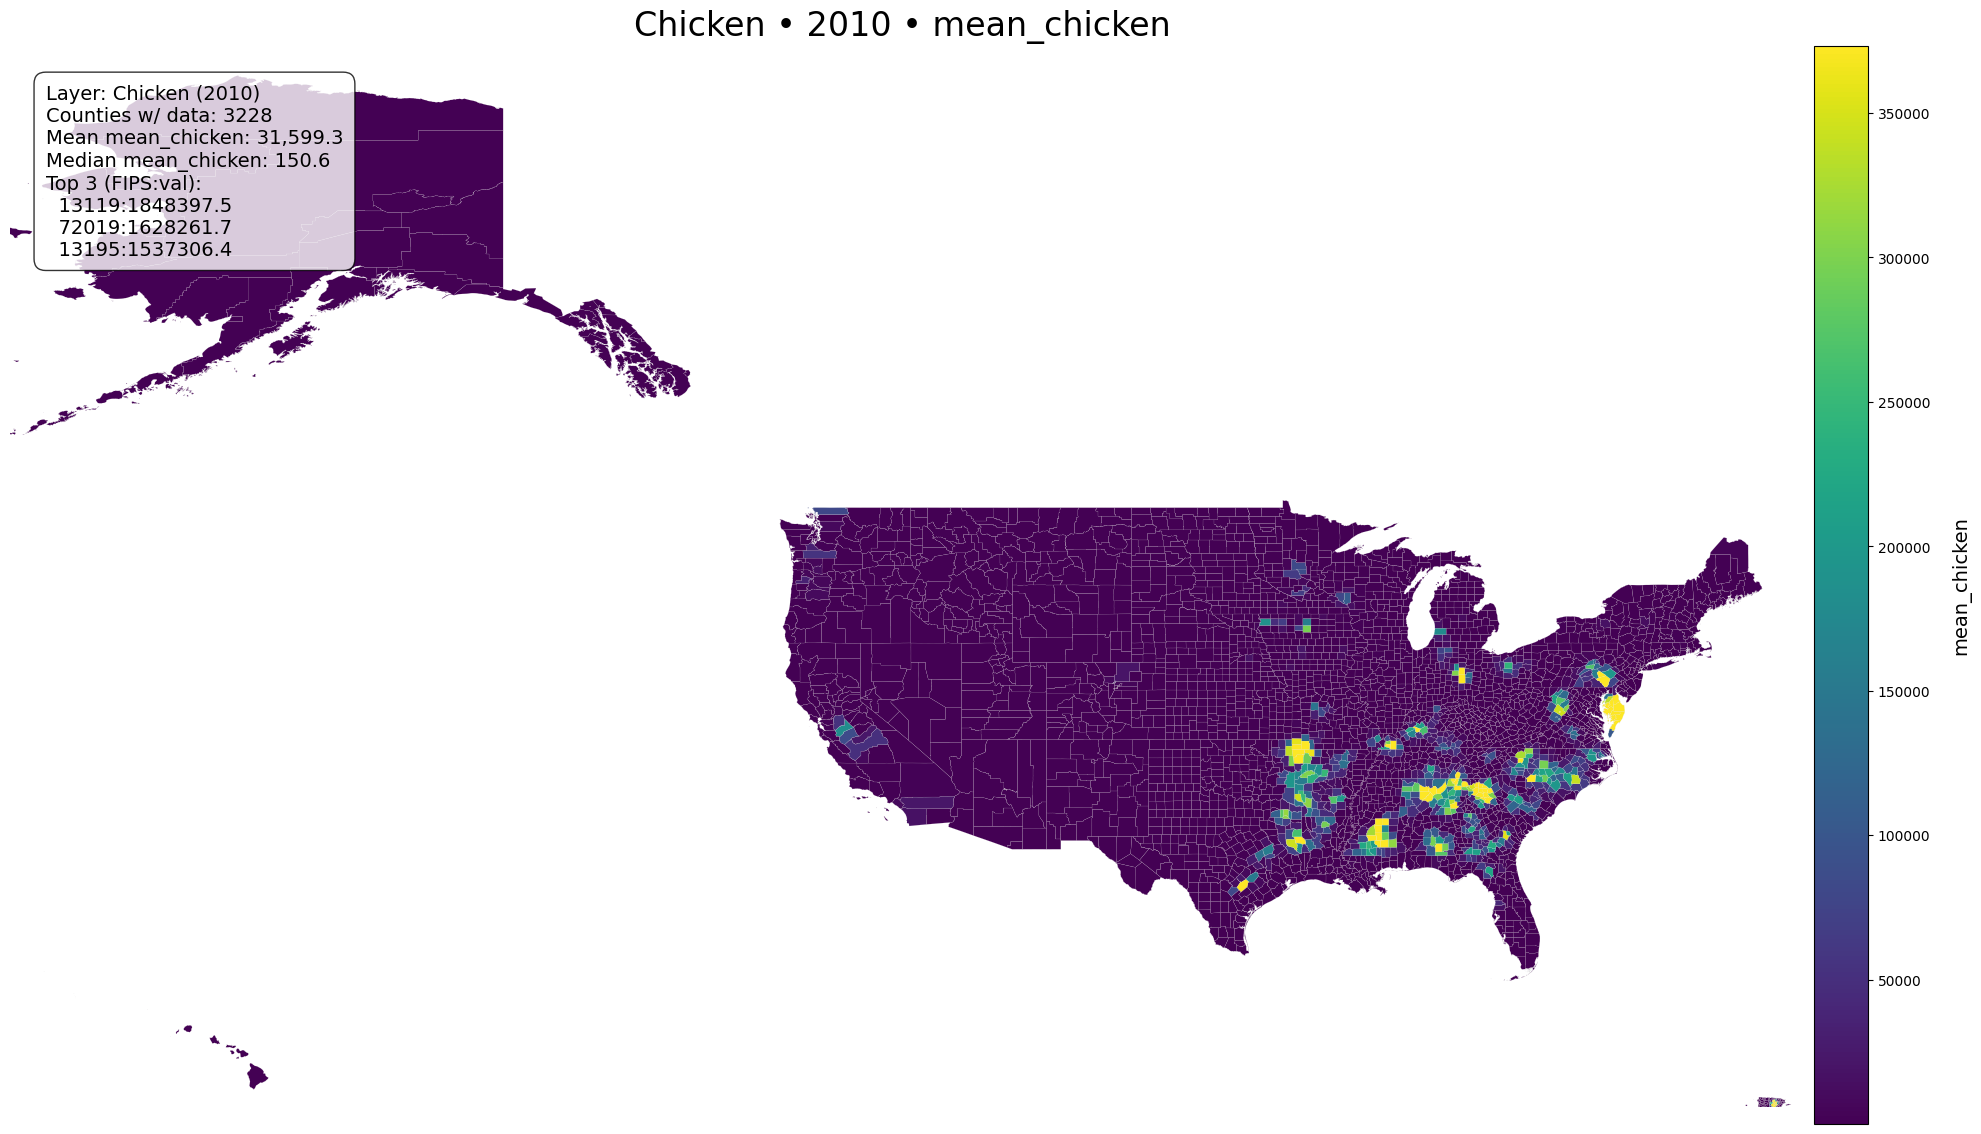

In [24]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ────────── STEP 0: user choices ──────────
COMBINED_CSV = Path("/Users/faizahmad/Desktop/NewLiv/data/summer 2025/combined_final_dataset_ML_DL.csv")
COUNTY_SHP   = Path("/Users/faizahmad/Desktop/NewLiv/data/cb_2023_us_county_500k.shp")

YEAR    = 2010                    # choose year between 2000–2019
SPECIES = "chicken"               # e.g. chicken, pig, cattle, etc.
METRIC  = "mean"                  # "sum", "mean", or "count"
# ──────────────────────────────────────────

# 1. Load & filter combined table --------------------------------------
df = pd.read_csv(COMBINED_CSV, dtype={"fips": str})
df["fips"] = df["fips"].str.zfill(5)

col_name = f"{METRIC}_{SPECIES}"
sub = df[(df["year"] == YEAR)].loc[:, ["fips", col_name]]

# 2. Load counties & harmonize FIPS ------------------------------------
g = gpd.read_file(COUNTY_SHP).to_crs("EPSG:4326")
geo_cols = [c for c in g.columns if c.upper().startswith("GEOID")]
chosen   = sorted(geo_cols, key=len)[0]
g = g.rename(columns={chosen: "fips"})
# drop other GEOID-like columns
for c in geo_cols:
    if c != chosen:
        g = g.drop(columns=c)
g["fips"] = g["fips"].astype(str).str.zfill(5)

# 3. Merge --------------------------------------------------------------
map_df = g.merge(sub, on="fips", how="left")

# 4. Colour stretch (clip 2–98 %) --------------------------------------
vals = map_df[col_name].dropna()
vmin, vmax = np.percentile(vals, [2, 98]) if len(vals) else (0, 1)

# 5. Summary + top 3 -----------------------------------------------------
n_county = vals.count()
mean_v   = vals.mean()
med_v    = np.median(vals)
top3     = map_df.nlargest(3, col_name)[["fips", col_name]]
top3_list = [f"{row.fips}:{row[col_name]:.1f}" for _, row in top3.iterrows()]

textstr = (
    f"Layer: {SPECIES.title()} ({YEAR})\n"
    f"Counties w/ data: {n_county}\n"
    f"Mean {col_name}: {mean_v:,.1f}\n"
    f"Median {col_name}: {med_v:,.1f}\n"
    f"Top 3 (FIPS:val):\n  " + "\n  ".join(top3_list)
)

# 6. Plot (big) + zoom to US extents -----------------------------------
fig, ax = plt.subplots(figsize=(24, 14), dpi=100)
map_df.plot(column=col_name, cmap="viridis",
            ax=ax, vmin=vmin, vmax=vmax,
            linewidth=0.08, edgecolor="gainsboro")
ax.axis("off")
ax.set_title(f"{SPECIES.title()} • {YEAR} • {col_name}", fontsize=24, pad=20)

# zoom to include 48 states + AK & HI
ax.set_xlim(-170, -65)
ax.set_ylim(18, 72)

# 7. Colour bar ---------------------------------------------------------
sm = plt.cm.ScalarMappable(cmap="viridis",
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.01)
cbar.set_label(col_name, rotation=90, labelpad=15, fontsize=14)

# 8. Text box (stats + key features) -----------------------------------
bbox = dict(boxstyle="round,pad=0.6", facecolor="white", alpha=0.8)
ax.text(0.02, 0.98, textstr,
        transform=ax.transAxes,
        fontsize=14,
        verticalalignment="top",
        bbox=bbox)

plt.show()



It perfectly matches - additional confirmation that things are in good shape and data set is ready for ML DL

# Methodological Appendix: Building a County‑Level Annual U.S. Livestock Panel (2000–2019) and Integrating with Life Expectancy & Covariates

This document records—in reproducible detail—the data preparation workflow we executed to derive annual, county‑level livestock metrics from FAO Global Livestock production data (GLW v4 family) and merge them with a county‑year panel of life expectancy and related covariates ("LifeEX" dataset). The material here can be adapted directly into the **Methods / Data Processing** section of a manuscript.

---

## 1. Objectives

**Goal:** Create an analysis‑ready panel dataset for machine‑learning / deep‑learning models relating county‑level life expectancy (and other covariates) to livestock presence/scale/intensity.

**Constraints:**

* FAO GLW livestock rasters available only for **three temporal “anchor” years**: 2010, 2015, 2020.
* Analytical modeling window: **2000–2019** (calendar years matching LifeEX panel).
* We require **every U.S. county (FIPS)** retained, even if livestock is missing; territories retained for possible future use.
* Need multiple livestock metrics capturing *scale*, *intensity*, and *data support*.

**Deliverables:**

1. **`livestock_prepped_2000_2019.csv`** – interpolated annual livestock metrics (sum / mean / count) for every species, all counties, 2000–2019.
2. **`combined_final_dataset_ML_DL.csv`** – LifeEX panel outer‑joined with livestock metrics (no rows lost).

---

## 2. Data Sources

| Source                                                                     | Description                                               | Native CRS        | Resolution                  | Temporal Coverage | Notes                                                                                        |
| -------------------------------------------------------------------------- | --------------------------------------------------------- | ----------------- | --------------------------- | ----------------- | -------------------------------------------------------------------------------------------- |
| FAO GLW4 species rasters                                                   | Global grids of modeled livestock distribution by species | EPSG:4326         | 5 arc‑minutes (\~0.083333°) | 2010, 2015, 2020  | Pixel values proportional to modeled head counts / densities; nodata sentinels vary by file. |
| U.S. Census cartographic county shapefile (cb\_2023\_us\_county\_500k.shp) | Generalized county polygons incl. AK, HI, PR, territories | NAD83 (EPSG:4269) | n/a                         | static            | Used for zonal aggregation; reprojected to EPSG:4326 to match rasters.                       |
| LifeEX county panel                                                        | County‑year life expectancy + covariates                  | varies            | n/a                         | 2000–2019         | Contains `fips`, `year`, and 100+ features. Cleaned version used.                            |

---

## 3. Species Code Normalization

The GLW filenames and the intermediate CSV extracted from rasters encode species with short letter codes (e.g., `5_Ch_2010_Da`, `GLW4-2020.D-DA.CHK`). We created a canonical mapping to human‑readable species names used for column headers in the final dataset.

| GLW codes encountered | Final species name                           |
| --------------------- | -------------------------------------------- |
| CH, CHK               | **chicken**                                  |
| PG, PGS               | **pig**                                      |
| CT, CTL               | **cattle**                                   |
| GT, GTS               | **goat**                                     |
| SH, SHP               | **sheep**                                    |
| BF, BFL               | **buffalo**                                  |
| DK                    | **duck**                                     |
| HO                    | **horse**                                    |
| *any other*           | lower‑cased fallback of unknown code (rare). |

Implementation snippet:

```python
parts = species_str.split("_")
code  = parts[1].upper() if len(parts) > 1 else species_str.upper()
sp_name = code2name.get(code, code.lower())
```

---

## 4. Key Metrics Extracted from Rasters

From the zonal statistics computed for each county polygon against each species raster we retained three metrics (per county × species × anchor year):

* **`sum`** – Sum of pixel values within the county. Interpreted as an *estimated total head count* of that species in the county (subject to GLW modeling assumptions and pixel partial overlaps). This was previously stored as `head_count`.
* **`mean`** – Mean of pixel values across all valid (non‑nodata) pixels intersecting the county. Interpreted as an *average pixel density* (heads per 5′ cell; a relative intensity measure). Previously `mean_density`.
* **`count`** – Number of valid pixels contributing to the statistic (quality / support metric; loosely proportional to county area intersecting land cells). Previously `cell_count`.

We renamed the metrics at pivot time for shorter column names and explicit semantics in ML modeling.

---

## 5. Handling Nodata & Datatypes

GLW rasters use extreme negative sentinels that differ by product and year, e.g. `-1.7e308` (float64) or `-3.4e38` (float32). Before computing zonal statistics we explicitly passed the raster `nodata` to the stats function so these pixels were excluded. All outputs converted to floating point; nodata propagated as `NaN` in the derived CSV.

---

## 6. Spatial Harmonization & Zonal Statistics Workflow (one‑time extraction)

1. **Load rasters**; confirm metadata (extent, 4320×2160 grid, transform from -180..180, 90..-90). All in EPSG:4326.
2. **Load county shapefile**; reproject to EPSG:4326; drop duplicate GEOID‑like columns; pad to 5 digits.
3. **Zonal stats** (per raster):

   * Use vector->raster windowing to speed up (rasterstats or custom block read).
   * `nodata` passed from raster metadata.
   * Compute `sum`, `mean`, and count of valid pixels.
4. **Assemble long table**: columns = `GEOID`, `year`, `species`, `sum`, `mean`, `count`.
5. **Persist** intermediate CSV (`county_livestock_2010_2015_2020.csv`).

> *Performance note*: Because grid resolution is coarse and we have \~3k polygons, runtimes were modest; we tested parallelization but settled on a reliable serial/threaded hybrid after encountering pickling issues.

---

## 7. Building the Annual Livestock Panel (2000–2019)

### 7.1 Reshape to Wide Form

We pivoted the long table to a single row per county‑year, producing columns:

* `sum_<species>`
* `mean_<species>`
* `count_<species>`

Example columns: `sum_chicken`, `mean_pig`, `count_cattle`, …

```python
wide = (
  liv[["GEOID","year","sp_name","sum","mean","count"]]
    .pivot_table(index=["GEOID","year"], columns="sp_name",
                 values=["sum","mean","count"], aggfunc="first")
)
wide.columns = [f"{metric}_{sp}" for metric,sp in wide.columns]
wide = wide.reset_index()
```

### 7.2 Define Target Year Range

LifeEX panel spans 2000–2019, so we generated that range **plus 2020** (used only as an interpolation anchor then dropped).

```python
years_full = range(2000, 2021)  # includes 2020 anchor
```

### 7.3 Reindex to Full Grid

Create a complete county×year MultiIndex and reindex the wide table so missing rows appear as NaN.

```python
idx = pd.MultiIndex.from_product([wide["GEOID"].unique(), years_full],
                                 names=["GEOID","year"])
full = (wide.set_index(["GEOID","year"]).reindex(idx).reset_index())
```

### 7.4 Temporal Filling Logic

Let $L_{c,y}^s$ be the livestock metric for county *c*, species *s*, year *y*.

Anchor years available: 2010, 2015, 2020.

We define:

$$
L_{c,y}^s =
\begin{cases}
L_{c,2010}^s, & y \le 2010 \\
L_{c,2010}^s + \frac{y-2010}{5}\left(L_{c,2015}^s - L_{c,2010}^s\right), & 2010 < y < 2015 \\
L_{c,2015}^s + \frac{y-2015}{5}\left(L_{c,2020}^s - L_{c,2015}^s\right), & 2015 < y < 2020 \\
L_{c,2020}^s, & y \ge 2020
\end{cases}
$$

Implementation: vectorized group apply with `interpolate(method="linear", limit_area="inside").bfill().ffill()` after ordering years 2000–2020.

```python
metrics = [c for c in full.columns if c not in ("GEOID","year")]

def interp_fill(g):
    g = g.sort_values("year")
    g[metrics] = (
        g[metrics]
         .interpolate(method="linear", limit_area="inside")  # between anchors
         .bfill()  # backfill 2000–2009 w/ 2010 values
         .ffill()  # carry 2020 forward (not used after trimming)
    )
    return g

full = full.groupby("GEOID", group_keys=False).apply(interp_fill)
```

### 7.5 Trim to 2000–2019

After interpolation/backfill/forwardfill, we discard the 2020 rows:

```python
full = full[full["year"] <= 2019].copy()
```

### 7.6 Output

Saved as **`livestock_prepped_2000_2019.csv`**.

---

## 8. Integrating Livestock with LifeEX Panel

### 8.1 Inputs

* **LifeEX cleaned panel:** `fips`, `year`, 100+ covariate columns (2000–2019).
* **Livestock prepped panel:** `GEOID` (5‑char), `year`, livestock metrics.

### 8.2 Harmonize Keys

```python
lifeex["fips"] = lifeex["fips"].str.zfill(5)
liv["GEOID"]  = liv["GEOID"].str.zfill(5)
liv = liv.rename(columns={"GEOID":"fips"})
```

### 8.3 Full Outer Join (Preserve All Geography)

We elected **outer** rather than inner join because:

* LifeEX includes some counties lacking livestock data (retain them with NaNs).
* GLW includes territories (e.g., Puerto Rico 72xxx, Alaska census areas) not present in LifeEX (retain; may be used later or dropped selectively).

```python
combined = pd.merge(lifeex, liv, on=["fips","year"], how="outer")
combined.to_csv("combined_final_dataset_ML_DL.csv", index=False)
```

---

## 9. Quality Assurance / Validation Steps

We performed multiple checks at each stage.

### 9.1 Raster Spot Checks

* Printed raster metadata (dtype, nodata value) and read random pixel blocks to confirm nodata sentinel was being recognized.
* Verified at least some pixels within the conterminous U.S. had non‑nodata values.

### 9.2 Zonal Stats Sanity

* Tested a single county (e.g., Alameda CA) against a raster and compared mini‑raster extracts with returned stats.
* Confirmed `count` > 0 and `sum` nonzero for known livestock‑producing counties.

### 9.3 Aggregation Consistency Across Years & Species

* Ensured every raster delivered exactly 3 235 county rows (matching shapefile extents minus a few water/exception polygons).
* Confirmed dtype conversions (float64→float32) did not overflow small values.

### 9.4 Interpolation Validation

Randomly sampled counties and computed expected linear interpolation values:

```python
expected = v2010 + (v2015 - v2010) * (yr-2010)/5
```

for 2011–2014; analogous for 2016–2019 using 2015/2020 anchors. Differences were \~0 (floating tolerance).

### 9.5 Coverage Tallies

* Counted non‑null livestock metrics per year to ensure all 3 235 GLW counties populated for every year 2000–2019 after fill.
* Confirmed LifeEX‑only counties (no livestock) remain with NaNs → visible to modeling pipeline for optional imputation or exclusion.

### 9.6 Cartographic QA

Produced percentile‑clipped (2–98%) choropleths by species/year to visually inspect spatial patterns and detect gross anomalies or coding errors (e.g., swapped species, unit magnitudes).

---

## 10. Output Schema Summary

**Key columns (combined file):**

* `fips` – 5‑char county FIPS (string).
* `year` – int (2000–2019).
* *LifeEX variables* – as provided (life expectancy, socio‑demographic, weather, etc.).
* `sum_<species>` – total modeled head count in county.
* `mean_<species>` – average pixel value (relative density proxy).
* `count_<species>` – number of contributing raster pixels (quality / effective area proxy).

Example subset:

```
fips,year,lifeexp,weather_var,...,sum_chicken,mean_chicken,count_chicken,sum_cattle,...
01001,2000,75.2,123.4,...,  53200, 25.4, 38,  112000,...
```

---

## 11. Recommended Usage in Modeling

* **Scaling**: Livestock `sum_` features are highly skewed; log(x+1) transform recommended.
* **Density vs Sum**: Use both. `mean_` captures spatial intensity independent of county area; `sum_` captures total stock.
* **Data Support**: `count_` can be used as weight or to flag small‑area uncertainty.
* **Territory Handling**: Decide whether to include Puerto Rico, Alaska census areas, etc. For Continental U.S. only, filter by state FIPS not in {02,15,60,66,69,72,78}.
* **Missing Livestock**: Counties with NaNs (LifeEX‑only) can be zero‑filled *if* you interpret absence as no animals; otherwise treat as missing.

---

## 12. Reproducible Script Sequence

1. **Extract zonal stats** (raster → county table) → `county_livestock_2010_2015_2020.csv`.
2. **Prep livestock panel** (`prep_livestock.py`) → `livestock_prepped_2000_2019.csv`.
3. **Clean LifeEX** (remove extraneous cols, enforce FIPS) → `Cleaned_LifeEX_All_year_dataframe.csv`.
4. **Merge** (`join_lifeex_livestock.py`) → `combined_final_dataset_ML_DL.csv`.
5. **QA scripts**: run `analyze_datasets.py` to print coverage, overlaps, interpolation checks.
6. **Mapping**: use `plot_species_year.py` to visualize any species/year combination from the combined panel.

---

## 13. Minimal Reusable Functions (snippets)

### Species Column Builder

```python
def species_col(metric, species):
    return f"{metric}_{species}"  # metric in {sum,mean,count}
```

### Quick Choropleth from Combined

```python
import geopandas as gpd, pandas as pd, numpy as np, matplotlib.pyplot as plt

def plot_livestock(combined_csv, county_shp, year, species, metric="mean",
                   clip_pct=(2,98), figsize=(20,12), title=None):
    col = f"{metric}_{species}"
    df = pd.read_csv(combined_csv, dtype={"fips":str})
    df["fips"] = df["fips"].str.zfill(5)
    sub = df[df["year"]==year].loc[:, ["fips", col]]
    g  = gpd.read_file(county_shp).to_crs("EPSG:4326")
    geocols = [c for c in g.columns if c.upper().startswith("GEOID")]
    g = g.rename(columns={geocols[0]:"fips"})
    for c in geocols[1:]:
        g = g.drop(columns=c)
    g["fips"] = g["fips"].astype(str).str.zfill(5)
    m = g.merge(sub, on="fips", how="left")
    vals = m[col].dropna()
    vmin,vmax = np.percentile(vals,clip_pct) if len(vals) else (0,1)
    fig,ax = plt.subplots(figsize=figsize, dpi=110)
    m.plot(column=col, cmap="viridis", vmin=vmin, vmax=vmax,
           linewidth=0.05, edgecolor="gainsboro", ax=ax)
    ax.set_xlim(-170,-65); ax.set_ylim(18,72); ax.axis("off")
    ax.set_title(title or f"{species.title()} • {year} • {metric}")
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=vmin,vmax=vmax))
    sm._A=[]; plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.01, label=col)
    plt.show()
```

---

## 14. Limitations & Caveats

* GLW data are **modeled** distributions conditioned on national/sub‑national livestock statistics—not direct census counts; uncertainty varies spatially.
* Pixel values imply spatial redistribution, so `sum` at fine boundaries inherits modeling error from both the national inventory and spatial allocation model.
* County boundary changes over time are ignored; we used 2023 cartographic boundaries for all years (static geography assumption).
* Backfilling 2010 to years 2000–2009 assumes *stationarity*; may overstate historical variability if real pre‑2010 trends differ materially.
* Linear interpolation between 5‑year GLW snapshots cannot capture shocks (disease, policy, rapid intensification) that occurred between anchors.

---

## 15. Reproducibility Environment

* Python ≥ 3.11 (Conda env: `geo_ml`)
* Key packages: `pandas`, `geopandas`, `numpy`, `rasterio`, `rasterstats` (or `rasterio.mask` + custom), `tqdm`, `matplotlib`.
* Processing performed on Apple Silicon (M‑series) laptop; memory footprint modest (<2 GB) due to coarse rasters.

---

### Contact / Change Log

* *2025‑07‑17*: Initial end‑to‑end build, interpolation, and merge complete.
* Subsequent edits: please append here.

---



In [32]:
import geopandas as gpd
import pandas as pd
from pathlib import Path

# ─── CONFIG: adjust paths if needed ─────────────────────────────
# ─── file paths: adjust as needed ──────────────────────────────
DATA_DIR        = Path("/Users/faizahmad/Desktop/NewLiv/data/summer 2025")
COMBINED_CSV    = DATA_DIR / "combined_final_dataset_ML_DL.csv"
COUNTY_SHP    = Path("/Users/faizahmad/Desktop/NewLiv/data/cb_2023_us_county_500k.shp")
STATE_SHP       = Path("/Users/faizahmad/Desktop/NewLiv/data/cb_2023_us_state_500k.shp")
# ───────────────────────────────────────────────────────────────
import pandas as pd
import geopandas as gpd
from pathlib import Path


# ──────────────────────────────

# 1️⃣ Load combined dataset
df = pd.read_csv(COMBINED_CSV, dtype={"fips": str})
df["fips"] = df["fips"].str.zfill(5)

# 2️⃣ Load county shapefile (to get full county roster)
counties = gpd.read_file(COUNTY_SHP)[["STATEFP","GEOID","NAME"]]
counties["GEOID"] = counties["GEOID"].astype(str).str.zfill(5)

# 3️⃣ Load state shapefile (for names/abbr)
states = gpd.read_file(STATE_SHP)[["STATEFP","STUSPS","NAME"]]
states["STATEFP"] = states["STATEFP"].astype(str).str.zfill(2)
states = states.rename(columns={
    "STATEFP":    "state",
    "STUSPS":     "state_abbr",
    "NAME":       "state_name"
})

# 4️⃣ Flag availability in the combined file
lifeex_col  = "MeanLifeExpectency"  # adjust if your column is named differently
liv_cols    = [c for c in df.columns if c.startswith(("sum_","mean_","count_"))]

df["has_lifeex"]    = df[lifeex_col].notna()
df["has_livestock"] = df[liv_cols].any(axis=1)

# Collapse to one record per county
county_flags = (
    df
    .groupby("fips")[["has_lifeex","has_livestock"]]
    .any()
    .reset_index()
)

# 5️⃣ Merge flags back to the full county roster
full = (
    counties
    .rename(columns={"GEOID": "fips"})
    .merge(county_flags, on="fips", how="left")
)
full["has_lifeex"]    = full["has_lifeex"].fillna(False)
full["has_livestock"] = full["has_livestock"].fillna(False)
full["state"]         = full["STATEFP"].astype(str).str.zfill(2)

# 6️⃣ State‑level aggregation
agg = (
    full
    .groupby("state")
    .apply(lambda d: pd.Series({
        "total_counties":   len(d),
        "with_lifeex":      d["has_lifeex"].sum(),
        "with_livestock":   d["has_livestock"].sum(),
        "with_both":        (d["has_lifeex"] & d["has_livestock"]).sum(),
        "with_either":      (d["has_lifeex"] | d["has_livestock"]).sum()
    }))
    .reset_index()
)

agg["only_lifeex"]    = agg["with_lifeex"]  - agg["with_both"]
agg["only_livestock"] = agg["with_livestock"] - agg["with_both"]
agg["missing_all"]    = agg["total_counties"] - agg["with_either"]

# 7️⃣ Add state names/abbr and reorder
agg = agg.merge(states, on="state", how="left")
cols = [
    "state","state_abbr","state_name","total_counties",
    "with_lifeex","with_livestock","with_both",
    "only_lifeex","only_livestock","missing_all"
]
agg = agg[cols].sort_values("state")

print("\n=== State‑level County Data Availability ===\n")
print(agg.to_string(index=False))

# 8️⃣ Show a few counties missing both datasets
missing = full[~full["has_lifeex"] & ~full["has_livestock"]][["state","fips","NAME"]]
print(f"\nCounties with no LifeEX & no livestock data: {len(missing)} (showing first 15)\n")
print(missing.head(15).to_string(index=False))

# 9️⃣ Notes
print("\nNotes:")
print("• IHME often suppresses county life‑expectancy for small populations (<10K) to protect privacy.")
print("• FAO GLW rasters can return all‐nodata over very small or water‐dominated areas.")
print("• County definitions evolve (new counties, independent cities) so some shapefile FIPS may not match IHME/FAO vintages.")



=== State‑level County Data Availability ===

state state_abbr                                   state_name  total_counties  with_lifeex  with_livestock  with_both  only_lifeex  only_livestock  missing_all
   01         AL                                      Alabama              67           67              67         67            0               0            0
   02         AK                                       Alaska              30           30              30         30            0               0            0
   04         AZ                                      Arizona              15           15              15         15            0               0            0
   05         AR                                     Arkansas              75           75              75         75            0               0            0
   06         CA                                   California              58           58              58         58            0               0       

/var/folders/gn/jjn1k9tj1djgvfsm130zqcxw0000gn/T/ipykernel_68621/3772583673.py:65: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: pd.Series({
